In [0]:
import pandas as pd
import numpy as np
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

import scipy.sparse as sp
import scipy.linalg as sparcyLinalg
import collections

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
import nltk
nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


True

In [0]:
BASE_DIR = '/content/drive/My Drive/ngram_model/'
DATASETS_PATH = BASE_DIR

In [0]:
def load_data(filename_train, filename_test, filename_val):
    """
    Load train, test and validation sets from file

    Args:
        filename_train : Name of the file from which the train data is to be loaded
        filename_test : Name of the file from which the test data is to be loaded
        filename_val : Name of the file from which the validation data is to be loaded
    
    Returns:
        train_tweet_X: list of tweets from train data
        train_tweet_Y: list of lables correponding to each tweet from train data
        test_tweet_X: list of tweets from test data
        test_tweet_Y: list of lables correponding to each tweet from test data
        val_tweet_X: list of tweets from validation data
        val_tweet_Y: list of lables correponding to each tweet from validation data
    """
    train = pd.read_csv(filename_train)
    test = pd.read_csv(filename_test)
    val = pd.read_csv(filename_val)
    
    return train['Text'].tolist(), train['Label'].tolist(), test['Text'].tolist(), test['Label'].tolist(), val['Text'].tolist(), val['Label'].tolist()

In [0]:
# LOADING TRAIN, TEST AND VALIDATION SETS

train_tweet_X, train_tweet_Y, test_tweet_X, test_tweet_Y, val_tweet_X, val_tweet_Y = load_data(DATASETS_PATH + 'train.csv', DATASETS_PATH + 'test.csv', DATASETS_PATH + 'val.csv')

print("Train length: \t", len(train_tweet_X))
print("Test length: \t", len(test_tweet_X))
print("Val length: \t", len(val_tweet_X))

Train length: 	 40231
Test length: 	 11833
Val length: 	 7100


In [0]:
class LanguageModel:
    def __init__(self, docs, n):
        """
        Initialize an n-gram language model.
        
        Args:
            docs: list of strings, where each string represents a space-separated
                  document
            n: integer, degree of n-gram model
        """
#         print(docs)
        self.counts = collections.defaultdict(dict) # Dict from space-separated "previous words" to a Dict of (next word, count). 
        self.count_sums = collections.Counter() # Dict from space-separated "previous words" to the total number of times they appear
        
        self.num = n

        self.dictionary=[]
        
        for document in docs:
            # splitting
            document_words = document.split()
            
            self.dictionary = self.dictionary + document_words
            
            #length of document_words
            size = len(document_words)
            
            for i in range(size - n + 1):
                
                previous = " ".join(document_words[i:i+n-1])
                #keeping track of curr
                current = document_words[i + n - 1]
                
                self.count_sums[previous] = self.count_sums[previous] + 1
                
                if previous in self.counts.keys():
                    if current in self.counts[previous].keys():
                        count = self.counts[previous][current]
                        
                        self.counts[previous][current] = count + 1
                    
                    else:
                        self.counts[previous][current] = 1
                else:
                    self.counts[previous] = {current : 1}
    
    def perplexity(self, text, alpha=1e-3):
        """
        Evaluate perplexity of model on some text.
        
        Args:
            text: string containing space-separated words, on which to compute
            alpha: constant to use in Laplace smoothing
            
        Note: for the purposes of smoothing, the dictionary size (i.e, the D term)
        should be equal to the total number of unique words used to build the model
        _and_ in the input text to this function.
            
        Returns: perplexity
            perplexity: floating point value, perplexity of the text as evaluted
                        under the model.
        """
        probability = {}
        
        split_text = text.split()
        total_words = self.dictionary + split_text

        size_of_set = len(set(total_words))
        size = len(split_text)
        
        n = self.num
                
        probability = 0
        counter_previous = 0
        counter_curr = 0
        #looping over all
        for i in range(size - n + 1):
                text_previous = " ".join(split_text[i:i+n-1])
                
                current = split_text[i+n-1]
                counter_curr = 0
                
                if text_previous in self.count_sums.keys():
                    counter_previous  = self.count_sums[text_previous]
                    
                    if current in self.counts[text_previous].keys():
                        
                        counter_curr = self.counts[text_previous][current]
                    else :
                        counter_curr = 0
                else:
                    counter_previous = 0
                    counter_curr = 0
                    
                probability = probability + np.log((counter_curr + alpha) / (counter_previous + (alpha * size_of_set )))
                
        perplexity = np.exp(-1 * (probability / (size - n + 1)))
        
        return float(perplexity)

In [0]:
def get_perplexity(train_tweet_X, train_tweet_Y, test_tweet_X):
    # CREATING ARRAYS FOR EACH POLITICIANS TWEET IN train_tweet_X
    fawadchaudhry_tweets = []
    maryamnsharif_tweets = []
    mjibrannasir_tweets = []
    narendramodi_tweets = []
    sherryrehman_tweets = []

    for i, label in enumerate(train_tweet_Y):
      if label == 'fawadchaudhry':
        fawadchaudhry_tweets.append(train_tweet_X[i])
      elif label == 'maryamnsharif':
        maryamnsharif_tweets.append(train_tweet_X[i])
      elif label == 'mjibrannasir':
        mjibrannasir_tweets.append(train_tweet_X[i])
      elif label == 'narendramodi':
        narendramodi_tweets.append(train_tweet_X[i])
      elif label == 'sherryrehman':
        sherryrehman_tweets.append(train_tweet_X[i])


    fawadchaudhry_model = LanguageModel(fawadchaudhry_tweets, 5)
    maryamnsharif_model = LanguageModel(maryamnsharif_tweets, 5)
    mjibrannasir_model = LanguageModel(mjibrannasir_tweets, 5)
    narendramodi_model = LanguageModel(narendramodi_tweets, 5)
    sherryrehman_model = LanguageModel(sherryrehman_tweets, 5)

    perplexities = []
    for x in test_tweet_X:
      fawadchaudhry_perplexity = fawadchaudhry_model.perplexity(x)
      maryamnsharif_perplexity = maryamnsharif_model.perplexity(x)
      mjibrannasir_perplexity = mjibrannasir_model.perplexity(x)
      narendramodi_perplexity = narendramodi_model.perplexity(x)
      sherryrehman_perplexity = sherryrehman_model.perplexity(x)

      perplexities.append([fawadchaudhry_perplexity, maryamnsharif_perplexity, mjibrannasir_perplexity, narendramodi_perplexity, sherryrehman_perplexity])
    
    return perplexities

In [0]:
my_perplexities = get_perplexity(train_tweet_X, train_tweet_Y, test_tweet_X)

In [0]:
# Getting the predicted values by taking the minimum of the perplexities
predictions = []
politicians_list = ['fawadchaudhry', 'maryamnsharif', 'mjibrannasir', 'narendramodi', 'sherryrehman']
for i, avg_cos in enumerate(my_perplexities):
  index = my_perplexities[i].index(min(my_perplexities[i]))
  predictions.append(politicians_list[index])

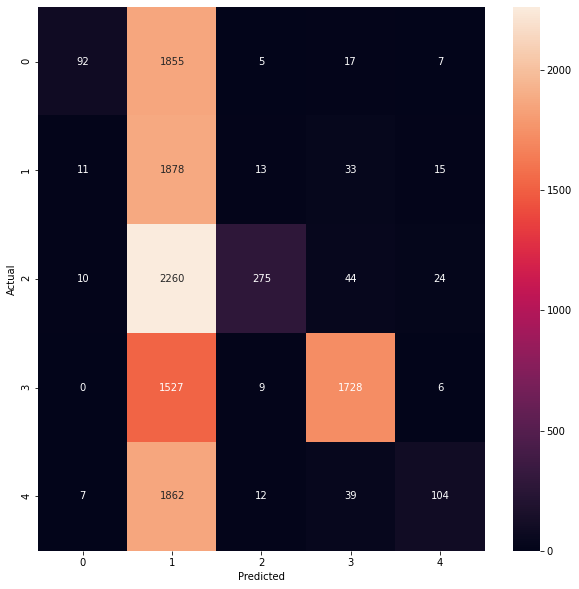

In [0]:
# Plotting Confusion Matrix

conf_mat = confusion_matrix(test_tweet_Y, predictions)
fig, ax = plt.subplots(figsize=(10,10))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=['0', '1', '2', '3', '4'], yticklabels=['0', '1', '2', '3', '4'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
print(classification_report(test_tweet_Y, predictions))

               precision    recall  f1-score   support

fawadchaudhry       0.77      0.05      0.09      1976
maryamnsharif       0.20      0.96      0.33      1950
 mjibrannasir       0.88      0.11      0.19      2613
 narendramodi       0.93      0.53      0.67      3270
 sherryrehman       0.67      0.05      0.10      2024

     accuracy                           0.34     11833
    macro avg       0.69      0.34      0.28     11833
 weighted avg       0.73      0.34      0.31     11833

